In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os, re, glob, parse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')
sns.set_palette('muted')

ligan_dir = '/pylon5/mc5phpp/mtragoza/liGAN'
sys.path.append(ligan_dir)

work_dir = os.path.join(ligan_dir, 'train_pdbbind')
os.chdir(work_dir)
os.getcwd()

'/pylon5/mc5phpp/mtragoza/liGAN/train_pdbbind'

In [2]:
def read_err_file(err_file):
    error = None
    with open(err_file, encoding='utf-8') as f:
        for line in f:
            if not re.match('Warning.*', line) and re.match(r'.*(Error|Exception|error|fault|failed).*', line):
                error = line.rstrip()
    return error

indent = '   '
train_output_files = []
for expt_name in ['loss_types']:
    print(expt_name)
    
    for job_name in reversed(sorted(os.listdir(expt_name))):
        print(indent + job_name)
        
        err_files = []
        for err_file in os.listdir(expt_name + '/' + job_name):
            
            m = re.match(r'slurm-(\d+)\.err', err_file)
            if not m:
                continue
                
            job_id = int(m.group(1))
            err_files.append((job_id, err_file))
            
        err_files = sorted(err_files)
            
        for job_id, err_file in err_files:
            error = read_err_file(expt_name + '/' + job_name + '/' + err_file)
            print(2*indent + err_file + indent + str(error)[:88])
        
        job_id = err_files[-1][0]
        train_output_file = glob.glob('/'.join([expt_name, job_name, str(job_id), '*.training_output']))[0]
        train_output_files.append(train_output_file)
        
        print()

len(train_output_files)

loss_types
   gen_e_disc_x_0
      slurm-7918326.err   F0227 02:14:27.740367 25613 filler.hpp:149] Check failed: blob->count()
      slurm-7928191.err   ValueError: could not broadcast input array from shape (50,16,48,48,48) into shape (16,1
      slurm-7928282.err   None
      slurm-7928317.err   slurmstepd: error: *** JOB 7928317 ON gpu054 CANCELLED AT 2020-02-28T03:46:05 DUE TO TIM
      slurm-7933632.err   FileNotFoundError: File b'gen_e_disc_x_0.lowrmsd.0.0.training_output' does not exist
      slurm-7940722.err   TypeError: write() argument must be str, not bytes
      slurm-7940726.err   slurmstepd: error: *** JOB 7940726 ON gpu051 CANCELLED AT 2020-03-01T22:36:53 DUE TO TIM
      slurm-7942975.err   slurmstepd: error: *** JOB 7942975 ON gpu050 CANCELLED AT 2020-03-02T11:08:37 DUE TO TIM
      slurm-7946801.err   slurmstepd: error: *** JOB 7946801 ON gpu054 CANCELLED AT 2020-03-02T22:07:57 ***
      slurm-7952678.err   slurmstepd: error: *** JOB 7952678 ON gpu052 CANCELLED AT 20

      slurm-8060137.err   slurmstepd: error: *** JOB 8060137 ON gpu049 CANCELLED AT 2020-03-10T23:40:59 DUE TO TIM
      slurm-8094436.err   slurmstepd: error: *** JOB 8094436 ON gpu054 CANCELLED AT 2020-03-12T13:35:53 DUE TO TIM
      slurm-8106534.err   slurmstepd: error: *** JOB 8106534 ON gpu053 CANCELLED AT 2020-03-13T07:37:04 DUE TO TIM
      slurm-8109369.err   slurmstepd: error: *** JOB 8109369 ON gpu057 CANCELLED AT 2020-03-13T23:04:26 DUE TO TIM
      slurm-8153055.err   slurmstepd: error: *** JOB 8153055 ON gpu052 CANCELLED AT 2020-03-17T06:54:16 DUE TO TIM
      slurm-8158170.err   slurmstepd: error: *** JOB 8158170 ON gpu049 CANCELLED AT 2020-03-17T22:24:04 DUE TO TIM
      slurm-8166217.err   slurmstepd: error: *** JOB 8166217 ON gpu050 CANCELLED AT 2020-03-19T04:22:55 DUE TO TIM
      slurm-8181547.err   slurmstepd: error: *** JOB 8181547 ON gpu049 CANCELLED AT 2020-03-20T08:47:41 DUE TO TIM
      slurm-8188438.err   slurmstepd: error: *** JOB 8188438 ON gpu049 CANCELLED

4

In [4]:
name_format = 'gen_{gen_loss_type}_disc_{disc_loss_type}_{random_seed}'

train_job_dfs = []
for train_output_file in train_output_files:
    try:
        train_job_df = pd.read_csv(train_output_file, sep=' ')
    except Exception as e:
        print(train_output_file, e, file=sys.stderr)
        continue
    
    expt_name, job_name, job_id, _ = train_output_file.split('/')
    out_file = '/'.join([expt_name, job_name, 'slurm-{}.out'.format(job_id)])
    err_file = '/'.join([expt_name, job_name, 'slurm-{}.err'.format(job_id)])
    
    train_job_df['expt_name'] = expt_name
    train_job_df['job_name'] = job_name
    train_job_df['job_id'] = int(job_id)
    train_job_df['out_file'] = out_file
    train_job_df['err_file'] = err_file
    
    # get params from job_name
    job_params = parse.parse(name_format, job_name).named
    for param, value in job_params.items():
        train_job_df[param] = value
    
    # get error from err_file
    train_job_df['job_error'] = read_err_file(err_file)
    
    train_job_df = train_job_df.rename(columns=dict({'test_data': 'phase'}))
    
    train_job_dfs.append(train_job_df)

train_df = pd.concat(train_job_dfs)
train_df.set_index(['expt_name', 'job_name', 'job_id'])

disc_grad_norm  disc_iter  disc_log_loss  \
expt_name  job_name       job_id                                              
loss_types gen_e_disc_x_0 8256112        1.000000        0.0       0.691774   
                          8256112        1.000000        0.0       0.692556   
                          8256112        1.000000      100.0       0.687724   
                          8256112        1.000000      100.0       0.687296   
                          8256112        1.000000      200.0       0.673901   
                          8256112        1.000000      200.0       0.675592   
                          8256112        1.000000      300.0       0.655680   
                          8256112        1.000000      300.0       0.649590   
                          8256112        1.000000      400.0       0.596971   
                          8256112        1.000000      400.0       0.587385   
                          8256112        1.000000      500.0       0.508500   
                          8256112        1.000000      500.0       0.527082   
                          8256112        1.000000      600.0       0.417864   
                          8256112        1.000000      600.0       0.418872   
                          8256112        1.000000      700.0       0.331207   
                          8256112        1.000000      700.0       0.373461   
                          8256112        1.000000      800.0       0.303788   
                          8256112        1.000000      800.0       0.357335   
                          8256112        1.000000      900.0       0.312355   
                          8256112        1.000000      900.0       0.355436   
                          8256112        1.000000     1000.0       0.345315   
                          8256112        1.000000     1000.0       0.337915   
                          8256112        1.000000     1100.0       0.236792   
                          8256112        1.000000     1100.0       0.322162   
                          8256112        1.000000     1200.0       0.233836   
                          8256112        1.000000     1200.0       0.288310   
                          8256112        0.955404     1300.0       0.297859   
                          8256112        1.000000     1300.0       0.271767   
                          8256112        0.925972     1400.0       0.313494   
                          8256112        0.970602     1400.0       0.357729   
...                                           ...        ...            ...   
           gen_a_disc_w_0 8256109        0.500000    98000.0            NaN   
                          8256109        0.500000    98000.0            NaN   
                          8256109        0.500000    98100.0            NaN   
                          8256109        0.500000    98100.0            NaN   
                          8256109        0.500000    98200.0            NaN   
                          8256109        0.500000    98200.0            NaN   
                          8256109        0.500000    98300.0            NaN   
                          8256109        0.500000    98300.0            NaN   
                          8256109        0.500000    98400.0            NaN   
                          8256109        0.500000    98400.0            NaN   
                          8256109        0.500000    98500.0            NaN   
                          8256109        0.500000    98500.0            NaN   
                          8256109        0.500000    98600.0            NaN   
                          8256109        0.500000    98600.0            NaN   
                          8256109        0.500000    98700.0            NaN   
                          8256109        0.500000    98700.0            NaN   
                          8256109        0.500000    98800.0            NaN   
                          8256109        0.500000    98800.0            NaN   
      

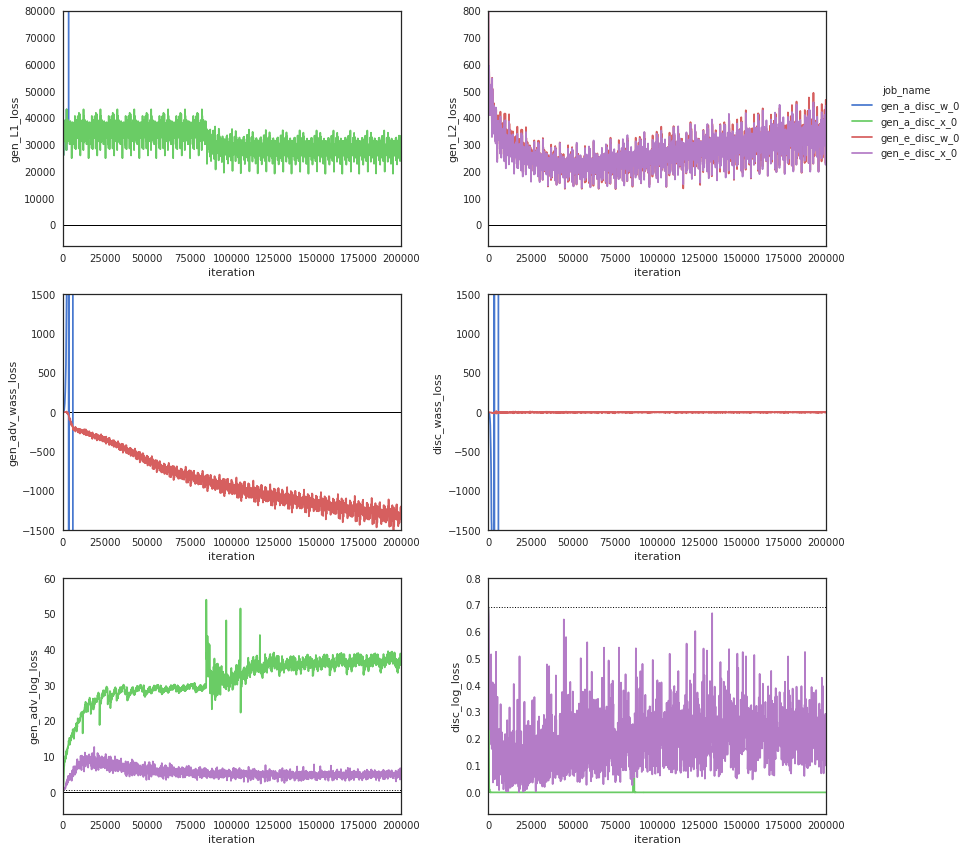

In [5]:
from collections import OrderedDict
from results import plot_lines

plot_df = train_df[train_df['phase'] == 'train']

ylim = OrderedDict([
    ('gen_L1_loss', (-8000, 80000)),
    ('gen_L2_loss', (-80, 800)),
    ('gen_adv_wass_loss', (-1500, 1500)),
    ('disc_wass_loss',    (-1500, 1500)),
    ('gen_adv_log_loss', (-6, 60)),
    ('disc_log_loss',    (-0.08, 0.8)),
])
y = ylim.keys()

fig = plot_lines('train_pdbbind_lines.png', plot_df, x='iteration', y=y,  hue='job_name',
                 ylim=ylim, n_cols=2, height=4, width=6)

In [6]:
indent = '    '
gen_metric_files = []

for expt_name in ['fit_pdbbind']:
    print(expt_name)
    
    for job_name in os.listdir(expt_name):
        
        if '.' in job_name: # skip files
            continue

        print(indent + job_name)
        
        job_ids = []
        for err_file in os.listdir(expt_name + '/' + job_name):
            
            m = re.match(r'slurm-(\d+)_(\d+)\.err', err_file)
            if not m:
                continue
                
            print(2*indent + err_file)
                
            job_id = int(m.group(1))
            array_idx = int(m.group(2))
            
            if array_idx >= 300:
                continue
            
            if job_id not in job_ids:
                job_ids.append(job_id)
                
        job_id = sorted(job_ids)[-1]
        
        gen_metric_pat = expt_name + '/' + job_name + '/' + str(job_id) + '/*.gen_metrics'
        gen_metric_files.extend(glob.glob(gen_metric_pat))
        print()

len(gen_metric_files)

fit_pdbbind
    gen_a_disc_x_0_100000_
        slurm-8110951_1.err
        slurm-8114899_1472.err
        slurm-8114899_416.err
        slurm-8114899_864.err
        slurm-8114899_1013.err
        slurm-8243471_566.err
        slurm-8114899_701.err
        slurm-8166264_3.err
        slurm-8114899_21.err
        slurm-8114899_360.err
        slurm-8243471_671.err
        slurm-8114899_1304.err
        slurm-8114899_659.err
        slurm-8243471_729.err
        slurm-8114899_238.err
        slurm-8114899_688.err
        slurm-8114899_818.err
        slurm-8188446_227.err
        slurm-8181556_193.err
        slurm-8114899_1378.err
        slurm-8181556_142.err
        slurm-8166264_82.err
        slurm-8114899_625.err
        slurm-8208254_440.err
        slurm-8114899_182.err
        slurm-8114899_244.err
        slurm-8114899_991.err
        slurm-8114899_1220.err
        slurm-8114899_295.err
        slurm-8114899_940.err
        slurm-8114899_532.err
        slurm-8114899_1137.err
 

        slurm-8166264_12.err
        slurm-8114899_1176.err
        slurm-8114899_573.err
        slurm-8114899_901.err
        slurm-8243471_714.err
        slurm-8114899_1261.err
        slurm-8114899_205.err
        slurm-8114899_664.err
        slurm-8208254_401.err
        slurm-8181556_104.err
        slurm-8114899_1499.err
        slurm-8114899_1029.err
        slurm-8114899_1448.err
        slurm-8188446_261.err
        slurm-8166264_15.err
        slurm-8114899_115.err
        slurm-8208254_370.err
        slurm-8114899_1171.err
        slurm-8114899_906.err
        slurm-8114899_574.err
        slurm-8114899_1266.err
        slurm-8243471_713.err
        slurm-8114899_202.err
        slurm-8114899_663.err
        slurm-8208254_406.err
        slurm-8243471_637.err
        slurm-8114899_1342.err
        slurm-8181556_178.err
        slurm-8114899_326.err
        slurm-8114899_481.err
        slurm-8114899_67.err
        slurm-8114899_1084.err
        slurm-8114899_747.err
    


    gen_e_disc_w_0_100000_r
        slurm-8166270_76.err
        slurm-8181562_132.err
        slurm-8208260_430.err
        slurm-8208260_397.err
        slurm-8208260_346.err
        slurm-8188452_260.err
        slurm-8181562_198.err
        slurm-8181562_149.err
        slurm-8188452_267.err
        slurm-8166270_71.err
        slurm-8181562_135.err
        slurm-8208260_390.err
        slurm-8208260_437.err
        slurm-8208260_341.err
        slurm-8181562_196.err
        slurm-8181562_147.err
        slurm-8208260_445.err
        slurm-8188452_269.err
        slurm-8208260_494.err
        slurm-8208260_333.err
        slurm-8208260_439.err
        slurm-8188452_215.err
        slurm-8166270_78.err
        slurm-8208260_399.err
        slurm-8188452_212.err
        slurm-8208260_348.err
        slurm-8181562_191.err
        slurm-8181562_140.err
        slurm-8208260_442.err
        slurm-8208260_334.err
        slurm-8208260_493.err
        slurm-8181562_109.err
        slurm-


    gen_e_disc_w_0_100000_rc
        slurm-8188453_252.err
        slurm-8208261_308.err
        slurm-8166271_60.err
        slurm-8188453_283.err
        slurm-8208261_402.err
        slurm-8208261_374.err
        slurm-8181563_107.err
        slurm-8188453_229.err
        slurm-8208261_405.err
        slurm-8208261_373.err
        slurm-8188453_255.err
        slurm-8208261_479.err
        slurm-8188453_284.err
        slurm-8166271_67.err
        slurm-8181563_109.err
        slurm-8188453_227.err
        slurm-8166271_15.err
        slurm-8181563_175.err
        slurm-8208261_477.err
        slurm-8208261_301.err
        slurm-8166271_69.err
        slurm-8181563_172.err
        slurm-8208261_470.err
        slurm-8208261_306.err
        slurm-8188453_220.err
        slurm-8166271_12.err
        slurm-8181563_147.err
        slurm-8166271_2.err
        slurm-8181563_196.err
        slurm-8208261_494.err
        slurm-8208261_333.err
        slurm-8208261_445.err
        slurm-818


    gen_e_disc_x_0_100000_rc
        slurm-8208265_447.err
        slurm-8208265_331.err
        slurm-8208265_496.err
        slurm-8181567_194.err
        slurm-8181567_145.err
        slurm-8166275_40.err
        slurm-8188457_217.err
        slurm-8166275_91.err
        slurm-8181567_139.err
        slurm-8166275_47.err
        slurm-8188457_210.err
        slurm-8166275_96.err
        slurm-8208265_440.err
        slurm-8208265_491.err
        slurm-8208265_336.err
        slurm-8181567_193.err
        slurm-8181567_142.err
        slurm-8166275_49.err
        slurm-8208265_395.err
        slurm-8208265_432.err
        slurm-8208265_344.err
        slurm-8166275_98.err
        slurm-8181567_130.err
        slurm-8166275_35.err
        slurm-8188457_262.err
        slurm-8208265_338.err
        slurm-8208265_449.err
        slurm-8166275_32.err
        slurm-8188457_265.err
        slurm-8208265_498.err
        slurm-8208265_435.err
        slurm-8208265_392.err
        slurm-8188


    gen_e_disc_w_0_100000_
        slurm-8208258_357.err
        slurm-8208258_386.err
        slurm-8208258_421.err
        slurm-8181560_135.err
        slurm-8166268_71.err
        slurm-8188450_267.err
        slurm-8181560_198.err
        slurm-8181560_149.err
        slurm-8188450_260.err
        slurm-8208258_350.err
        slurm-8208258_426.err
        slurm-8208258_381.err
        slurm-8181560_132.err
        slurm-8166268_76.err
        slurm-8181560_191.err
        slurm-8208258_322.err
        slurm-8208258_485.err
        slurm-8208258_454.err
        slurm-8181560_140.err
        slurm-8188450_212.err
        slurm-8208258_428.err
        slurm-8166268_78.err
        slurm-8188450_215.err
        slurm-8208258_359.err
        slurm-8208258_388.err
        slurm-8188450_269.err
        slurm-8181560_196.err
        slurm-8208258_482.err
        slurm-8208258_325.err
        slurm-8208258_453.err
        slurm-8181560_147.err
        slurm-8188450_220.err
        slurm-8


    gen_a_disc_x_0_100000_r
        slurm-8208256_477.err
        slurm-8208256_301.err
        slurm-8181558_172.err
        slurm-8166266_74.err
        slurm-8188448_217.err
        slurm-8243473_551.err
        slurm-8243473_697.err
        slurm-8243473_646.err
        slurm-8243473_580.err
        slurm-8243473_719.err
        slurm-8181558_175.err
        slurm-8166266_73.err
        slurm-8188448_210.err
        slurm-8243473_556.err
        slurm-8243473_690.err
        slurm-8243473_641.err
        slurm-8243473_587.err
        slurm-8181558_109.err
        slurm-8208256_470.err
        slurm-8208256_306.err
        slurm-8243473_717.err
        slurm-8208256_402.err
        slurm-8208256_374.err
        slurm-8243473_558.err
        slurm-8243473_589.err
        slurm-8181558_107.err
        slurm-8208256_308.err
        slurm-8188448_262.err
        slurm-8243473_524.err
        slurm-8243473_633.err
        slurm-8208256_479.err
        slurm-8188448_265.err
        slurm


    gen_e_disc_x_0_100000_
        slurm-8188454_287.err
        slurm-8188454_256.err
        slurm-8181564_178.err
        slurm-8166272_20.err
        slurm-8208262_370.err
        slurm-8208262_406.err
        slurm-8181564_104.err
        slurm-8181564_103.err
        slurm-8188454_280.err
        slurm-8188454_251.err
        slurm-8166272_27.err
        slurm-8208262_377.err
        slurm-8208262_401.err
        slurm-8188454_223.err
        slurm-8166272_55.err
        slurm-8208262_305.err
        slurm-8208262_473.err
        slurm-8166272_84.err
        slurm-8166272_5.err
        slurm-8166272_29.err
        slurm-8181564_171.err
        slurm-8208262_379.err
        slurm-8166272_2.err
        slurm-8188454_289.err
        slurm-8188454_258.err
        slurm-8188454_300.err
        slurm-8181564_176.err
        slurm-8208262_408.err
        slurm-8188454_224.err
        slurm-8166272_52.err
        slurm-8208262_302.err
        slurm-8208262_474.err
        slurm-8166272_


    gen_e_disc_x_0_100000_c
        slurm-8188455_296.err
        slurm-8188455_247.err
        slurm-8181565_169.err
        slurm-8208263_361.err
        slurm-8208263_417.err
        slurm-8181565_115.err
        slurm-8166273_79.err
        slurm-8181565_112.err
        slurm-8188455_291.err
        slurm-8188455_240.err
        slurm-8208263_366.err
        slurm-8208263_410.err
        slurm-8188455_232.err
        slurm-8166273_77.err
        slurm-8208263_314.err
        slurm-8208263_462.err
        slurm-8181565_160.err
        slurm-8208263_368.err
        slurm-8188455_298.err
        slurm-8188455_249.err
        slurm-8181565_167.err
        slurm-8208263_419.err
        slurm-8188455_235.err
        slurm-8166273_70.err
        slurm-8208263_313.err
        slurm-8208263_465.err
        slurm-8166273_39.err
        slurm-8181565_183.err
        slurm-8181565_152.err
        slurm-8166273_45.err
        slurm-8166273_94.err
        slurm-8166273_1.err
        slurm-82082


    gen_a_disc_w_0_100000_
        slurm-8181552_125.err
        slurm-8114894_1819.err
        slurm-8188442_291.err
        slurm-8243467_630.err
        slurm-8114894_158.err
        slurm-8114894_539.err
        slurm-8114894_94.err
        slurm-8114894_45.err
        slurm-8166260_8.err
        slurm-8243467_527.err
        slurm-8114894_2669.err
        slurm-8114894_2208.err
        slurm-8114894_189.err
        slurm-8188442_240.err
        slurm-8114894_1624.err
        slurm-8114894_1183.err
        slurm-8208250_351.err
        slurm-8114894_2731.err
        slurm-8114894_2096.err
        slurm-8114894_317.err
        slurm-8114894_1245.err
        slurm-8114894_1990.err
        slurm-8114894_2350.err
        slurm-8114894_776.err
        slurm-8114894_2381.err
        slurm-8114894_2426.err
        slurm-8114894_1294.err
        slurm-8114894_1941.err
        slurm-8114894_1533.err
        slurm-8114894_813.err
        slurm-8114894_461.err
        slurm-8114894_2047.err


        slurm-8114894_1053.err
        slurm-8243467_669.err
        slurm-8114894_101.err
        slurm-8114894_2280.err
        slurm-8114894_2527.err
        slurm-8114894_1395.err
        slurm-8114894_1840.err
        slurm-8114894_1432.err
        slurm-8188442_219.err
        slurm-8114894_1344.err
        slurm-8114894_1891.err
        slurm-8114894_2251.err
        slurm-8114894_677.err
        slurm-8114894_1725.err
        slurm-8114894_1082.err
        slurm-8114894_2630.err
        slurm-8114894_2197.err
        slurm-8114894_216.err
        slurm-8114894_409.err
        slurm-8114894_2788.err
        slurm-8243467_700.err
        slurm-8114894_1929.err
        slurm-8114894_2338.err
        slurm-8208250_339.err
        slurm-8114894_2759.err
        slurm-8114894_2260.err
        slurm-8114894_646.err
        slurm-8243467_689.err
        slurm-8188442_228.err
        slurm-8114894_1375.err
        slurm-8114894_2601.err
        slurm-8114894_580.err
        slurm-811489

        slurm-8114896_2123.err
        slurm-8114896_2684.err
        slurm-8114896_1036.err
        slurm-8114896_1791.err
        slurm-8181553_135.err
        slurm-8188443_281.err
        slurm-8114896_2542.err
        slurm-8114896_919.err
        slurm-8114896_1457.err
        slurm-8114896_1825.err
        slurm-8243468_672.err
        slurm-8114896_394.err
        slurm-8114896_841.err
        slurm-8114896_433.err
        slurm-8114896_76.err
        slurm-8208251_437.err
        slurm-8208251_390.err
        slurm-8208251_341.err
        slurm-8114896_1279.err
        slurm-8114896_345.err
        slurm-8114896_890.err
        slurm-8114896_724.err
        slurm-8114896_1618.err
        slurm-8114896_2248.err
        slurm-8114896_1888.err
        slurm-8114896_261.err
        slurm-8114896_2629.err
        slurm-8114896_600.err
        slurm-8181553_198.err
        slurm-8243468_519.err
        slurm-8181553_149.err
        slurm-8114896_176.err
        slurm-8114896_517.err


    gen_a_disc_x_0_100000_rc
        slurm-8243474_644.err
        slurm-8243474_582.err
        slurm-8243474_553.err
        slurm-8181559_125.err
        slurm-8188449_291.err
        slurm-8166267_14.err
        slurm-8188449_240.err
        slurm-8166267_8.err
        slurm-8243474_638.err
        slurm-8181559_159.err
        slurm-8208257_387.err
        slurm-8208257_420.err
        slurm-8166267_68.err
        slurm-8208257_356.err
        slurm-8181559_188.err
        slurm-8243474_528.err
        slurm-8208257_427.err
        slurm-8208257_380.err
        slurm-8208257_351.err
        slurm-8243474_643.err
        slurm-8243474_585.err
        slurm-8243474_554.err
        slurm-8188449_296.err
        slurm-8181559_122.err
        slurm-8166267_13.err
        slurm-8188449_247.err
        slurm-8243474_631.err
        slurm-8243474_526.err
        slurm-8181559_150.err
        slurm-8166267_61.err
        slurm-8208257_429.err
        slurm-8188449_235.err
        slurm-81


    gen_a_disc_w_0_100000_rc
        slurm-8243470_509.err
        slurm-8114898_2432.err
        slurm-8114898_2395.err
        slurm-8114898_1955.err
        slurm-8114898_1527.err
        slurm-8114898_1280.err
        slurm-8114898_2053.err
        slurm-8114898_479.err
        slurm-8114898_1146.err
        slurm-8114898_1197.err
        slurm-8114898_1630.err
        slurm-8114898_2082.err
        slurm-8114898_2725.err
        slurm-8114898_1984.err
        slurm-8114898_1251.err
        slurm-8114898_2344.err
        slurm-8243470_746.err
        slurm-8114898_982.err
        slurm-8114898_1768.err
        slurm-8114898_257.err
        slurm-8208253_370.err
        slurm-8181555_178.err
        slurm-8114898_16.err
        slurm-8114898_191.err
        slurm-8114898_1309.err
        slurm-8114898_636.err
        slurm-8114898_140.err
        slurm-8208253_406.err
        slurm-8114898_953.err
        slurm-8114898_521.err
        slurm-8114898_286.err
        slurm-8114898_192

        slurm-8114898_1825.err
        slurm-8166263_84.err
        slurm-8181555_181.err
        slurm-8188445_235.err
        slurm-8114898_2542.err
        slurm-8208253_389.err
        slurm-8114898_1791.err
        slurm-8114898_509.err
        slurm-8114898_1036.err
        slurm-8114898_2684.err
        slurm-8114898_2123.err
        slurm-8243470_521.err
        slurm-8114898_797.err
        slurm-8114898_451.err
        slurm-8114898_823.err
        slurm-8114898_1618.err
        slurm-8114898_327.err
        slurm-8114898_480.err
        slurm-8243470_636.err
        slurm-8114898_1279.err
        slurm-8114898_746.err
        slurm-8114898_203.err
        slurm-8208253_483.err
        slurm-8208253_324.err
        slurm-8243470_712.err
        slurm-8114898_2629.err
        slurm-8166263_29.err
        slurm-8114898_42.err
        slurm-8114898_1888.err
        slurm-8114898_662.err
        slurm-8114898_2248.err
        slurm-8188445_298.err
        slurm-8188445_249.err
  

        slurm-8114897_2087.err
        slurm-8114897_712.err
        slurm-8114897_1370.err
        slurm-8114897_2265.err
        slurm-8114897_1711.err
        slurm-8114897_373.err
        slurm-8114897_22.err
        slurm-8114897_2604.err
        slurm-8114897_2172.err
        slurm-8114897_405.err
        slurm-8114897_877.err
        slurm-8114897_1067.err
        slurm-8114897_2513.err
        slurm-8114897_1874.err
        slurm-8114897_1406.err
        slurm-8181554_187.err
        slurm-8188444_233.err
        slurm-8114897_1698.err
        slurm-8243469_644.err
        slurm-8243469_582.err
        slurm-8208252_428.err
        slurm-8243469_553.err
        slurm-8114897_1228.err
        slurm-8243469_695.err
        slurm-8114897_1649.err
        slurm-8181554_156.err
        slurm-8166262_44.err
        slurm-8114897_1789.err
        slurm-8114897_1758.err
        slurm-8166262_95.err
        slurm-8114897_1339.err
        slurm-8114897_1600.err
        slurm-8114897_262.


    gen_a_disc_x_0_100000_c
        slurm-8243472_605.err
        slurm-8208255_461.err
        slurm-8208255_317.err
        slurm-8243472_512.err
        slurm-8188447_206.err
        slurm-8181557_163.err
        slurm-8166265_6.err
        slurm-8166265_62.err
        slurm-8243472_679.err
        slurm-8243472_721.err
        slurm-8166265_65.err
        slurm-8243472_569.err
        slurm-8181557_118.err
        slurm-8243472_726.err
        slurm-8166265_19.err
        slurm-8243472_602.err
        slurm-8208255_466.err
        slurm-8208255_310.err
        slurm-8243472_515.err
        slurm-8188447_201.err
        slurm-8181557_164.err
        slurm-8166265_1.err
        slurm-8243472_670.err
        slurm-8208255_414.err
        slurm-8208255_362.err
        slurm-8243472_567.err
        slurm-8188447_273.err
        slurm-8181557_116.err
        slurm-8243472_728.err
        slurm-8166265_17.err
        slurm-8208255_468.err
        slurm-8166265_10.err
        slurm-820825

1200

In [7]:
name_format = 'gen_{gen_loss_type}_disc_{disc_loss_type}_{random_seed}_{iteration}_'

fit_job_dfs = []
for gen_metric_file in gen_metric_files:
    try:
        fit_job_df = pd.read_csv(gen_metric_file, sep=' ')
    except Exception as e:
        print(gen_metric_file, e, file=sys.stderr)
        continue
    
    expt_name, job_name, job_id, _ = gen_metric_file.split('/')
    #out_file = '/'.join([expt_name, job_name, 'slurm-{}.out'.format(job_id)])
    #err_file = '/'.join([expt_name, job_name, 'slurm-{}.err'.format(job_id)])
    
    fit_job_df['expt_name'] = expt_name
    fit_job_df['job_name'] = job_name
    fit_job_df['job_id'] = int(job_id)
    #fit_job_df['out_file'] = out_file
    #fit_job_df['err_file'] = err_file
    
    # get params from job_name
    job_name, fit_options = job_name.rsplit('_', 1)
    job_params = parse.parse(name_format, job_name+'_').named
    for param, value in job_params.items():
        fit_job_df[param] = value
        
    fit_job_df['random_rotation'] = 'r' in fit_options
    fit_job_df['constrain_types'] = 'c' in fit_options
    
    # get error from err_file
    #fit_job_df['job_error'] = read_err_file(err_file)
    
    fit_job_dfs.append(fit_job_df)

fit_df = pd.concat(fit_job_dfs)

In [7]:
fit_df.columns

Index(['lig_name', 'sample_idx', 'lig_norm', 'lig_gen_norm', 'lig_gen_loss',
       'lig_var', 'lig_gen_var', 'lig_fit_loss', 'lig_gen_fit_loss',
       'lig_n_atoms', 'lig_fit_n_atoms', 'lig_gen_fit_n_atoms', 'lig_radius',
       'lig_fit_radius', 'lig_gen_fit_radius', 'lig_fit_type_diff',
       'lig_gen_fit_type_diff', 'lig_fit_RMSD', 'lig_gen_fit_RMSD',
       'lig_fit_time', 'lig_gen_fit_time', 'lig_fit_error',
       'lig_gen_fit_error', 'lig_fit_n_frags', 'lig_gen_fit_n_frags',
       'expt_name', 'job_name', 'job_id', 'gen_loss_type', 'disc_loss_type',
       'random_seed', 'iteration', 'random_rotation', 'constrain_types'],
      dtype='object')

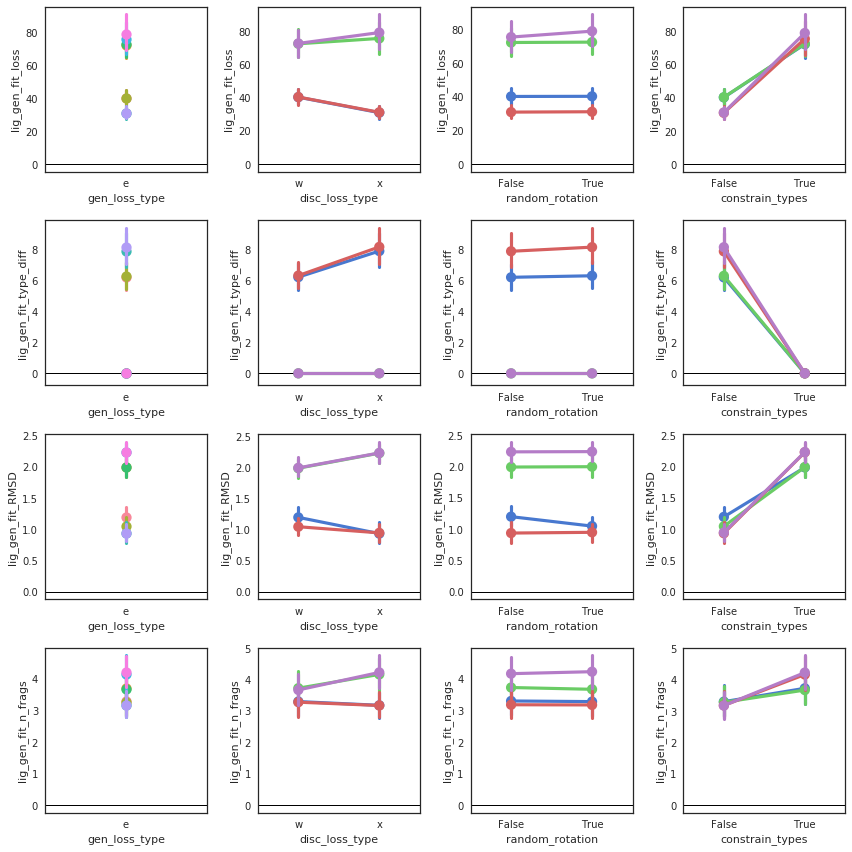

In [15]:
from results import aggregate_data, add_group_column, plot_strips

params = ['gen_loss_type', 'disc_loss_type', 'random_rotation', 'constrain_types']

plot_df = aggregate_data(fit_df, params+['lig_name']).reset_index()

for p in params:
    add_group_column(plot_df, [c for c in params if c != p])

metrics = [
    'lig_fit_time',
    'lig_gen_fit_time',
    'lig_fit_loss',
    'lig_gen_fit_loss',
    'lig_fit_type_diff',
    'lig_gen_fit_type_diff',
    'lig_fit_RMSD',
    'lig_gen_fit_RMSD',
    'lig_fit_n_frags',
    'lig_gen_fit_n_frags'
]

metrics = [
    'lig_gen_fit_loss',
    'lig_gen_fit_type_diff',
    'lig_gen_fit_RMSD',
    'lig_gen_fit_n_frags'
]


fig = plot_strips('fit_pdbbind_strips.png', plot_df[plot_df['gen_loss_type'] == 'e'], x=params, y=metrics, grouped=True,
                  n_cols=4, height=3, width=3, point=True)


In [18]:
print(plot_df.columns)

Index(['gen_loss_type', 'disc_loss_type', 'random_rotation', 'constrain_types',
       'lig_name', 'sample_idx', 'lig_norm', 'lig_gen_norm', 'lig_gen_loss',
       'lig_var', 'lig_gen_var', 'lig_fit_loss', 'lig_gen_fit_loss',
       'lig_n_atoms', 'lig_fit_n_atoms', 'lig_gen_fit_n_atoms', 'lig_radius',
       'lig_fit_radius', 'lig_gen_fit_radius', 'lig_fit_type_diff',
       'lig_gen_fit_type_diff', 'lig_fit_RMSD', 'lig_gen_fit_RMSD',
       'lig_fit_time', 'lig_gen_fit_time', 'lig_fit_error',
       'lig_gen_fit_error', 'lig_fit_n_frags', 'lig_gen_fit_n_frags',
       'expt_name', 'job_name', 'job_id', 'random_seed', 'iteration',
       '(disc_loss_type, random_rotation, constrain_types)',
       '(gen_loss_type, random_rotation, constrain_types)',
       '(gen_loss_type, disc_loss_type, constrain_types)',
       '(gen_loss_type, disc_loss_type, random_rotation)'],
      dtype='object')


/opt/packages/anaconda3.5/lib/python3.6/site-packages/seaborn/distributions.py:214: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)
/opt/packages/anaconda3.5/lib/python3.6/site-packages/seaborn/distributions.py:214: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)
/opt/packages/anaconda3.5/lib/python3.6/site-packages/seaborn/distributions.py:214: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)
/opt/packages/anaconda3.5/lib/python3.6/site-packages/seaborn/distributions.py:214: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


blue = WGAN, green = GAN


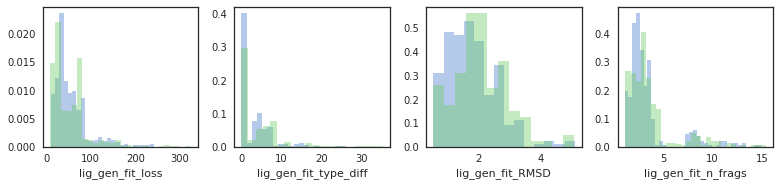

In [24]:
from results import plot_dist

fig = plot_dist('fit_pdbbind_dist.png', plot_df[(plot_df['gen_loss_type'] == 'e')], x=metrics, hue='disc_loss_type', height=2.75, width=2.75, n_cols=5, kde=False)
print('blue = WGAN, green = GAN')

/opt/packages/anaconda3.5/lib/python3.6/site-packages/seaborn/distributions.py:214: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)
/opt/packages/anaconda3.5/lib/python3.6/site-packages/seaborn/distributions.py:214: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)
/opt/packages/anaconda3.5/lib/python3.6/site-packages/seaborn/distributions.py:214: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)
/opt/packages/anaconda3.5/lib/python3.6/site-packages/seaborn/distributions.py:214: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


blue = constrained, green = unconstrained


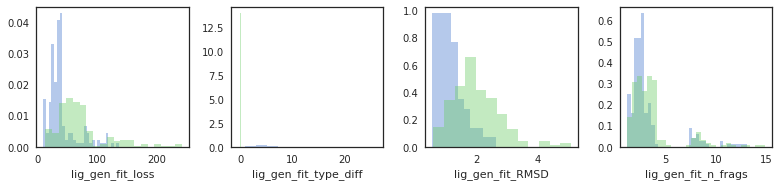

In [25]:
from results import plot_dist

fig = plot_dist('fit_pdbbind_dist.png', plot_df[(plot_df['gen_loss_type'] == 'e') & (plot_df['disc_loss_type'] == 'w')], x=metrics, hue='constrain_types', height=2.75, width=2.75, n_cols=5, kde=False)
print('blue = constrained, green = unconstrained')

/opt/packages/anaconda3.5/lib/python3.6/site-packages/seaborn/distributions.py:214: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)
/opt/packages/anaconda3.5/lib/python3.6/site-packages/seaborn/distributions.py:214: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)
/opt/packages/anaconda3.5/lib/python3.6/site-packages/seaborn/distributions.py:214: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)
/opt/packages/anaconda3.5/lib/python3.6/site-packages/seaborn/distributions.py:214: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


blue = no random rotation, green = random rotation


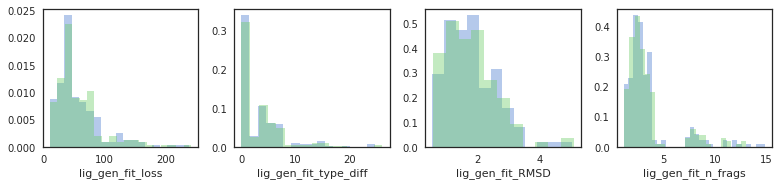

In [26]:
fig = plot_dist('fit_pdbbind_dist.png', plot_df[(plot_df['gen_loss_type'] == 'e') & (plot_df['disc_loss_type'] == 'w')], x=metrics, hue='random_rotation', height=2.75, width=2.75, n_cols=5, kde=False)
print('blue = no random rotation, green = random rotation')